In [575]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, random
from tabulate import tabulate
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
from keras import applications
import gc
import tensorflow as tf
from skimage import data, io, filters
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [576]:
gc.collect()

31650

In [577]:
data_dir  = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


**Transformations**

In [578]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)


In [579]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

In [580]:
base_path = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2527


In [581]:
random_seed = 42
torch.manual_seed(random_seed)

In [582]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

**We have equal poplulation of all classes of data**

Text(0, 0.5, 'population')

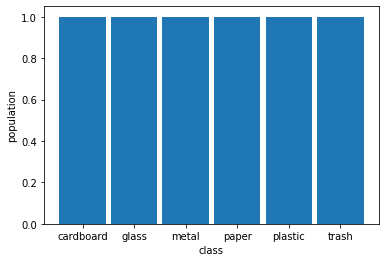

In [583]:
plt.hist(dataset.classes, bins=np.arange(7)-0.5, rwidth=0.9)
plt.xlabel('class')
plt.ylabel('population')

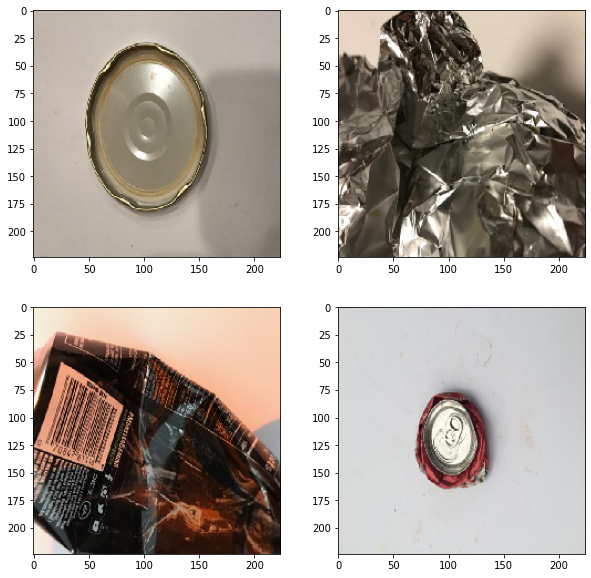

In [584]:
plt.figure(figsize=(10,10))
for i in range(0,4):
  img = tf.keras.preprocessing.image.load_img(img_list[i+1],target_size=(224,224))
  img = tf.keras.preprocessing.image.img_to_array(img,dtype=np.uint8)
  plt.subplot(2,2,i+1)
  plt.imshow(img)

In [585]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [586]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

**Modelbase**

In [587]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [588]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

**GPU Porting**

In [589]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [590]:
device = get_default_device()
device

device(type='cuda')

In [591]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


to_device(model, device) removed

**Training the model**

In [592]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [593]:
model = to_device(ResNet(), device)

In [594]:
evaluate(model, val_dl)

{'val_loss': 1.7843793630599976, 'val_acc': 0.2083333283662796}

In [595]:
num_epochs =8
opt_func = torch.optim.Adam
lr = 5.5e-5



In [596]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4612, val_loss: 1.2557, val_acc: 0.8299
Epoch 2: train_loss: 1.1672, val_loss: 1.1515, val_acc: 0.9410
Epoch 3: train_loss: 1.0938, val_loss: 1.1072, val_acc: 0.9653
Epoch 4: train_loss: 1.0735, val_loss: 1.1383, val_acc: 0.9149
Epoch 5: train_loss: 1.0628, val_loss: 1.1106, val_acc: 0.9479
Epoch 6: train_loss: 1.0576, val_loss: 1.1109, val_acc: 0.9531
Epoch 7: train_loss: 1.0556, val_loss: 1.0974, val_acc: 0.9670
Epoch 8: train_loss: 1.0542, val_loss: 1.0911, val_acc: 0.9722


Trying Restnet50

In [597]:
# from keras.models import Sequential
# from sklearn.model_selection import KFold
# import numpy

# dataset = np.loadtxt("iris_data.csv", delimiter=",")
# split into input (X) and output (Y) variables
# data_values= train_data[0:1589]
# X = data_values[0:794]
# Y = data_values[795:1589]
# # define 10-fold cross validation test harness
# kfold = KFold(n_splits=10, shuffle=True, random_state=40)
# cvscores = []
# for train, test in kfold.split(X, Y):
#     # create model
    
#     #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # Fit the model
#     model.fit(X[train], Y[train], epochs=8, batch_size=10, verbose=0)
#     #model.fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
#     # evaluate the model
#     scores = model.evaluate(X[test], Y[test], verbose=0)
#     print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#     cvscores.append(scores[1] * 100)
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [598]:
# history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

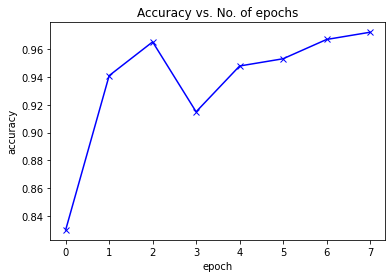

In [599]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

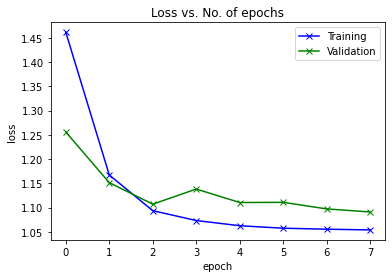

In [600]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-gx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [601]:
#dataset_path = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/'
img_list = glob.glob(os.path.join(data_dir,'*/*.jpg'))

In [602]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [603]:
train_generator = train_generator.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

Found 2276 images belonging to 6 classes.


In [604]:
test_generator = test_generator.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 503 images belonging to 6 classes.


In [605]:
model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False, weights='imagenet')

In [606]:
input_layer = model.layers[0].input
inputs= model.layers[-1].output
x = tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides=(1,1),activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(6,activation='sigmoid')(x)
model_value = tf.keras.Model(input_layer,x)

In [607]:
model.trainable=False

In [608]:
model_value.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [609]:
myModel.fit(train_generator,validation_data=test_generator,epochs=10,batch_size=32)

Epoch 1/10
143/143 [==============================] - 33s 229ms/step - loss: 0.3224 - accuracy: 0.8844 - val_loss: 0.6277 - val_accuracy: 0.8151
Epoch 2/10
143/143 [==============================] - 32s 226ms/step - loss: 0.3054 - accuracy: 0.8796 - val_loss: 0.3433 - val_accuracy: 0.8748
Epoch 3/10
143/143 [==============================] - 32s 223ms/step - loss: 0.3097 - accuracy: 0.8822 - val_loss: 0.3302 - val_accuracy: 0.8668
Epoch 4/10
143/143 [==============================] - 32s 223ms/step - loss: 0.2741 - accuracy: 0.9007 - val_loss: 0.3227 - val_accuracy: 0.8787
Epoch 5/10
143/143 [==============================] - 32s 225ms/step - loss: 0.2660 - accuracy: 0.9007 - val_loss: 0.3055 - val_accuracy: 0.9026
Epoch 6/10
143/143 [==============================] - 32s 224ms/step - loss: 0.2514 - accuracy: 0.9143 - val_loss: 0.3349 - val_accuracy: 0.8847
Epoch 7/10
143/143 [==============================] - 32s 222ms/step - loss: 0.2438 - accuracy: 0.9029 - val_loss: 0.3920 - val_ac

**End of code**


In [610]:
# def get_default_device():
#     """Pick GPU if available, else CPU"""
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')
    
# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list,tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)
# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
        
#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl: 
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)

# device = get_default_device()
# device


In [611]:
# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
#         # 1 input image channel, 6 output channels, 5x5 square convolution
#         # kernel
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension 
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         # Max pooling over a (2, 2) window
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square, you can specify with a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features


# net = Net()
# print(net)

In [612]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [613]:
# model = Sequential([
#     Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
#     MaxPooling2D(pool_size=2),

#     Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
#     MaxPooling2D(pool_size=2),
    
#     Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
#     MaxPooling2D(pool_size=2),
    
#     Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
#     MaxPooling2D(pool_size=2),

#     Flatten(),

#     Dense(64, activation='relu'),

#     Dense(6, activation='softmax')
# ])

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# model.summary()

In [614]:
# model.fit_generator(train_generator, epochs=20, validation_data=validation_generator)

In [615]:
# test_x, test_y = validation_generator.__getitem__(1)

# preds = model.predict(test_x)

# plt.figure(figsize=(16, 16))
# for i in range(16):
#     plt.subplot(4, 4, i+1)
#     plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
#     plt.imshow(test_x[i])